# import module

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from glob import glob

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
gpu_on = False

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "detect_lvi"
batch_size = 16
on_memory = False
argumentation_proba = 0.8
preprocess_input = sm.get_preprocessing(BACKBONE)
target_size = (512,512)
interpolation = "bilinear"
dtype = "float32"


train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/image/train/*/*")
train_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/mask/train/*/*")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/image/valid/*/*")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/mask/valid/*/*")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/image/test/*/*")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/mask/test/*/*")

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=0.8,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                 mask_path_list=test_mask_path_list,
                                 batch_size=batch_size,
                                 on_memory=False,
                                 argumentation_proba=0,
                                 preprocess_input=preprocess_input,
                                 target_size=target_size,
                                 interpolation=interpolation,
                                 shuffle=False,
                                 dtype=dtype
                                 )

Total data num 8608
Total data num 1609
Total data num 1469


In [4]:
np.random.seed(1337)  # for reproducibility

# create the base pre-trained model~
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

In [ ]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import WeightedRegionLoss, TverskyLoss, dice_score, dice_loss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./weights/{task}/{data_set_name}/{today_str}/target_size_{target_size}/" 
today_logs_path = f"./logs/{task}/{data_set_name}/{today_str}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-3, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


def make_model_trainable(epoch, model, target_epoch):
    if epoch > target_epoch:
        for layer in model.layers:
            layer.trainable = True
            
make_trainable_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: make_model_trainable(epoch, model, target_epoch=epoch_release_frozen)
)

model.compile(optimizer=optimizer, loss=WeightedRegionLoss(), metrics=[dice_score])

In [4]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger, make_trainable_callback],
    initial_epoch=start_epoch
)

NameError: name 'model' is not defined

# Unused Code

In [5]:
from matplotlib import pyplot as plt
import albumentations as A

In [15]:
index = 1234

data = train_data_loader.data_getter[index]

image_array = data["image_array"]
image_array = (image_array + 1) * 127.5
image_array = image_array.astype("uint8")

mask_array = data["mask_array"]
mask_array = (mask_array) * 255
mask_array = mask_array.astype("uint8")

final_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5)
],
    p=1)


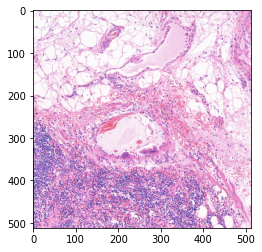

In [16]:
plt.imshow(image_array)

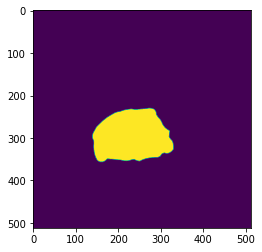

In [17]:
plt.imshow(mask_array)

In [18]:
import csv

with open('./U_net/vessel_level_1_512_random_org/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

FileNotFoundError: [Errno 2] No such file or directory: './U_net/vessel_level_1_512_random_org/log.csv'

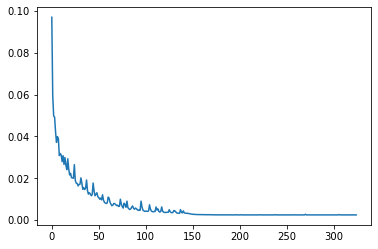

In [30]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.show()

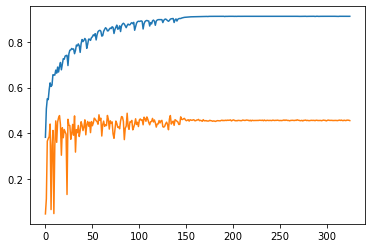

In [32]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()

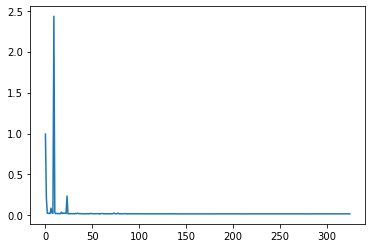

In [29]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["val_loss"])
plt.show()